In [73]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
from bayesian_pdes.problems import allen_cahn
import bayesian_design as bd
import sympy as sp
import scipy.stats
import os
#%load_ext line_profiler
import time
import Cython
%load_ext Cython
import mcmc
%load_ext mcmc
%mcmc notebook

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [74]:
n_pts = 20
n_bdy = 5
seed = 1
np.random.seed(seed)
noise_variance = 1e-2

# NB including both sample_ls and use_fem is pointless since the ls has no impact in this case
sample_ls = True
bayesian_approach = False

use_fem = False
fem_mesh_size = 50

In [75]:
x, y = np.mgrid[0:1:n_bdy*1j, 0:1:n_bdy*1j]
x = x.ravel(); y = y.ravel()

on_bdy = (x == 0.) | (x == 1.) | (y == 0.) | (y == 1.)

collocate_boundary = np.c_[x[on_bdy], y[on_bdy]]
grid_interior = np.column_stack([x[~on_bdy], y[~on_bdy]])

initial_design = np.random.rand(n_pts, 2)

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(locations.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = boundary_rhs(collocate_boundary)

In [76]:
def cube_root(arr):
    arr = np.asarray(arr)
    ret = np.empty_like(arr)
    ret[arr >= 0] = arr[arr > 0]**(1./3)
    ret[arr < 0] = - np.abs(arr[arr < 0])**(1./3)
    return ret

# Calculation of Importance Distn

In [77]:
from deflation.deflation import ForwardProblem
from deflation.petscsnessolver import PetscSnesSolver
import dolfin
from dolfin import dx
import math
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [78]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [79]:
import sys
args = [sys.argv[0]] + """
                       --petsc.snes_max_it 200
                       --petsc.snes_monitor
                       --petsc.snes_converged_reason
                       --petsc.snes_stol 0.0
                       --petsc.snes_rtol 0.0
                       --petsc.snes_type newtonls
                       --petsc.snes_linesearch_type basic

                       --petsc.ksp_type gmres
                       --petsc.ksp_rtol 1.0e-12
                       --petsc.ksp_atol 1.0e-12

                       --petsc.inner_pc_type lu
                       """.split()
dolfin.parameters.parse(argv=args)

In [80]:
meshes = {}
fn_spaces = {}
bc_store = {}
def find_solutions(delta, mesh_points, initial_guesses=None, max_solutions=3, stop_on_divergence=False):
    # reuse mesh if we can
    if mesh_points in meshes:
        mesh = meshes[mesh_points]
        V = fn_spaces[mesh_points]
        bcs = bc_store[mesh_points]
    else:
        mesh = dolfin.UnitSquareMesh(mesh_points, mesh_points)
        size = dolfin.MPI.size(dolfin.mpi_comm_world())
        if size > 1:
            nrefine = math.log(size, 4)
            if int(nrefine) != nrefine:
                print("Need to have processors a power of 4, as each refinement multiplies work by 4")
                assert False

            for i in range(int(nrefine) + 3):
                mesh = dolfin.refine(mesh, redistribute=False)
        meshes[mesh_points] = mesh

        V = dolfin.FunctionSpace(mesh, "CG", 1)
        fn_spaces[mesh_points] = V
        

        bcs = [dolfin.DirichletBC(V, +1.0, "x[0] == 0.0 || x[0] == 1"),
               dolfin.DirichletBC(V, -1.0, "x[1] == 0.0 || x[1] == 1")]
        bc_store[mesh_points] = bcs
    Vdim = V.dim()
    #if dolfin.MPI.rank(dolfin.mpi_comm_world()) == 0:
    #    print "Degrees of freedom: ", Vdim
    #    print "Degrees of freedom per core: ", Vdim/float(size)

    delta = dolfin.Constant(delta)

    u = dolfin.Function(V)

    v = dolfin.TestFunction(V)
    F = delta * dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dx + 1.0/delta * dolfin.inner(v, u**3 - u)*dx

    power = 1
    shift = 0.1
    problem = ForwardProblem(F, V, u, bcs, power=power, shift=shift)
    solver = PetscSnesSolver()

    roots = []
    natol = 1.0e-8

    for i in xrange(max_solutions):
        if initial_guesses is not None and len(initial_guesses) > i:
            u.assign(initial_guesses[i])
        dolfin.PETScOptions.set("snes_atol", natol)
        try:
            solver.solve(problem, u.vector())
        except Exception as ex:
            if stop_on_divergence:
                break
            else:
                raise
            
        roots.append(dolfin.Function(u, name="Solution"))

        u.assign(dolfin.Constant(0))
        problem.deflate(roots[-1])
        if shift > 0:
            natol *= shift
    return roots

In [81]:
def compute_latent(points, delta, solutions):
    # it is most convenient to compute the latent variables as the cube of the values at the points (i.e. at A_2),
    # since this means we don't have to fuss about with gradients.
    res = np.empty((points.shape[0], len(solutions)))
    for i in xrange(len(solutions)):
        res[:,i] = np.vectorize(solutions[i])(points[:,0], points[:,1])
    return -res**3 / delta

In [82]:
delta = 0.04
true_solutions = find_solutions(delta, 50, max_solutions=3, stop_on_divergence=False)

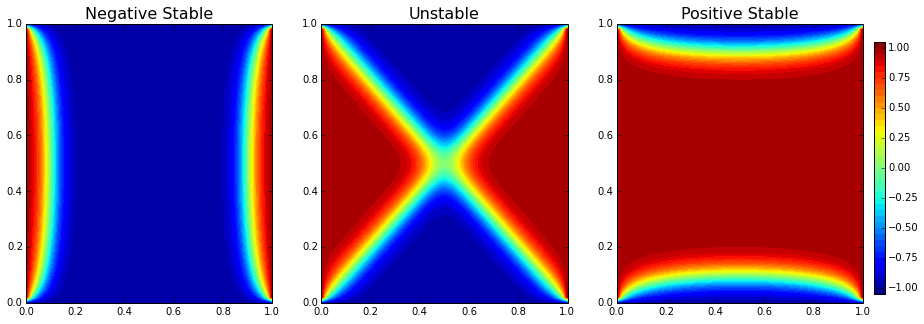

In [83]:

test_x, test_y = np.mgrid[0:1:50j, 0:1:50j]
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
titles = [
    'Negative Stable',
    'Unstable',
    'Positive Stable'
]
for ix, solution in enumerate(true_solutions):
    z = np.vectorize(solution)(test_x, test_y)
    ax = axes[ix]
    res = ax.contourf(test_x, test_y, z, 50)
    ax.set_title(titles[ix], fontsize=16)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(res, cax=cbar_ax)
plt.savefig('figures/ac_ref_solutions.pdf', transparent=True, bbox_inches=0)

In [84]:
true_solution_ix = 1

data_x, data_y = np.mgrid[0:1:6j, 0:1:6j]
flags = (data_x > 0) & (data_x < 1) & (data_y > 0) & (data_y < 1)
data_x = data_x[flags].reshape((4,4))
data_y = data_y[flags].reshape(4,4)
data_pts = np.c_[data_x.ravel(), data_y.ravel()]
#bdy_eps = 0.05
#data_pts = np.array([
#        [bdy_eps, 0.5], 
#        [1-bdy_eps, 0.5],
#        [0.5, bdy_eps], 
#        [0.5, 1-bdy_eps], 
#        [0.2, 0.2],
#        [0.2, 0.8],
#        [0.8, 0.2],
#        [0.8, 0.8],
#        [0.5, 0.5]])
true_solution = true_solutions[true_solution_ix]
true_solution_values = np.vectorize(true_solution)(data_pts[:,0], data_pts[:,1])

true_solution_values = true_solution_values + np.random.normal(0, noise_variance)
true_obs = (data_pts, true_solution_values)

A sensible range looks like $\delta \in [0.035, 0.1]$. It looks (however) as though while it becomes difficult to find solutions after this point, the three-solution regime is not broken until closer to $\delta=0.2$

# Calculation of PN Probability

In [85]:
init_ls = 0.1

In [86]:
from scipy.spatial import distance
z_length_scale = init_ls
# TODO: update after initial design
kern_mat = np.exp(-distance.cdist(initial_design, initial_design) / (2*z_length_scale**2))
#z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), kern_mat)

In [87]:
x_1, x_2, y_1, y_2 = sp.symbols('x_1 x_2 y_1 y_2')
sigma = sp.symbols('sigma')
k_sqexp = sp.exp(-((x_1 - y_1)**2 + (x_2 - y_2)**2) / (2*sigma**2))

In [88]:
allen_cahn_system_factory = allen_cahn.AllenCahnFactory(k_sqexp, [x_1, x_2], [y_1, y_2], [sigma])

In [89]:
test_x, test_y = np.mgrid[0:1:10j, 0:1:10j]
test = np.column_stack([test_x.ravel(), test_y.ravel()])

In [90]:
def sample_forward_posterior(delta, solutions, length_scale, z_rho, n_samples, interior_design, mixture, test_pts):
    op_cache = allen_cahn_system_factory.get_operator_system(delta, use_cache=(not sample_ls))
    ops = op_cache.operators
    ops_bar = op_cache.operators_bar

    z = compute_latent(interior_design, delta, solutions)
    #dist = scipy.stats.multivariate_normal(np.zeros_like(z[:, mixture_ix], rho)
    #dist = scipy.stats.norm(0, rho)


    #z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), rho)
    z_dist = scipy.stats.multivariate_normal(np.zeros(interior_design.shape[0]), z_rho**2*kern_mat)
    #z_dist = scipy.stats.norm(0, rho)
    estimates = np.empty(n_samples)

    obs = [
        (interior_design, None),
        (interior_design, None),
        (collocate_boundary, None)
    ]
    
    posterior = bayesian_pdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=np.array([length_scale]))
    true_locations, true_values = true_obs
    dot_with_rhs, cov = posterior.no_obs_posterior(test_pts)
    mean = np.zeros((n_samples, test_pts.shape[0]))

    all_rvs = z_dist.rvs(n_samples)
    for i in xrange(n_samples):
        # equal weighting for solutions
        rv = all_rvs[i]
        z_star = z[:, mixture] + rv
        rhs = np.concatenate([z_star, cube_root(-delta*z_star), boundary_obs])
        mu = dot_with_rhs.dot(rhs)
        mean[i,:] = mu
    return mean, cov

(0, 1)

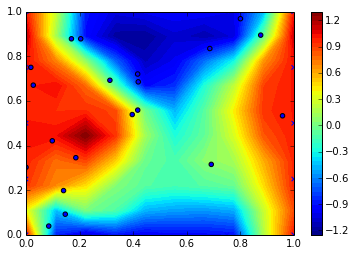

In [91]:
mean, cov = sample_forward_posterior(0.04, true_solutions, init_ls, 1e-3, 500, initial_design, true_solution_ix, test)
plt.contourf(test_x, test_y, mean.mean(axis=0).reshape(test_x.shape), 50)
plt.colorbar()
plt.scatter(initial_design[:,0], initial_design[:,1])
plt.scatter(collocate_boundary[:,0], collocate_boundary[:,1], marker='x')
plt.xlim([0,1]); plt.ylim([0,1])

In [92]:
def log_p_pn_estimate(true_obs, delta, solutions, length_scale, sigma, rho, n_samples, mixture, design, debug=False):
    means, cov = sample_forward_posterior(delta, solutions, length_scale, rho, n_samples, design, mixture, data_pts)
    
    estimates = np.empty(n_samples)
    
    error_mat = np.eye(cov.shape[0])*sigma**2
    Sigma_plus_error = cov + error_mat
    if debug: print(np.trace(cov), np.trace(Sigma_plus_error))
    if bayesian_approach:
        like_dist = scipy.stats.multivariate_normal(np.zeros(data_pts.shape[0]), Sigma_plus_error)
    else:
        like_dist = scipy.stats.multivariate_normal(np.zeros(data_pts.shape[0]), error_mat)
    
    for i in xrange(n_samples):
        mu = means[i, :]
        discrepancy = mu - true_solution_values
        log_pn_proba = like_dist.logpdf(discrepancy)
        
        estimates[i] = log_pn_proba
        if debug:
            print('i={}: Log-PN Proba: {} Discrepancy: {}' \
                .format(i, log_pn_proba, discrepancy.mean()))
    #if debug:
    #    print estimates
    return estimates

6.82171864 6.82331864
i=0: Log-PN Proba: -13902.1742981 Discrepancy: 0.0392014555826
i=1: Log-PN Proba: -13902.4445569 Discrepancy: 0.0391692507456
i=2: Log-PN Proba: -13902.5137141 Discrepancy: 0.0391630404937
i=3: Log-PN Proba: -13902.4742737 Discrepancy: 0.0391562660607
i=4: Log-PN Proba: -13902.476722 Discrepancy: 0.0391634164148
i=5: Log-PN Proba: -13902.3870795 Discrepancy: 0.0391169887548
i=6: Log-PN Proba: -13902.7171234 Discrepancy: 0.0391691043194
i=7: Log-PN Proba: -13903.2254129 Discrepancy: 0.0391547276774
i=8: Log-PN Proba: -13902.9844083 Discrepancy: 0.0391943667316
i=9: Log-PN Proba: -13902.5112814 Discrepancy: 0.039173946147
i=10: Log-PN Proba: -13902.6816505 Discrepancy: 0.0391255507633
i=11: Log-PN Proba: -13903.4147891 Discrepancy: 0.0391711966217
i=12: Log-PN Proba: -13902.4476431 Discrepancy: 0.0392099213915
i=13: Log-PN Proba: -13903.0420092 Discrepancy: 0.0391661544178
i=14: Log-PN Proba: -13902.1560769 Discrepancy: 0.0391551730832
i=15: Log-PN Proba: -13902.828

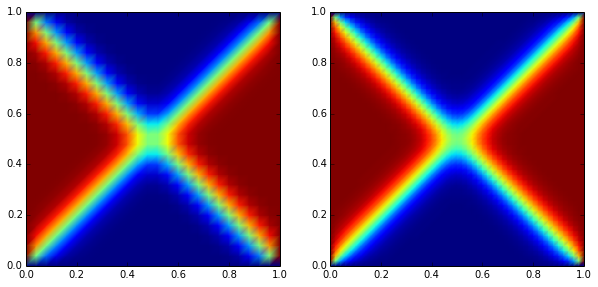

In [93]:
match_solution_ix = 2
cur_solutions = find_solutions(0.04, 25)
plt.figure(figsize=(10,5))
plt.subplot(121)
plot(cur_solutions[match_solution_ix])
plt.subplot(122)
plot(true_solution)
e = log_p_pn_estimate(true_obs, 0.04, cur_solutions, init_ls, noise_variance, 1e-4, 50, match_solution_ix, initial_design, debug=True)
print(np.mean(e), np.std(e))

# Optimal Experiment Design

In [94]:
def get_cov(points):
    if points.shape == (2,):
        points = points.reshape((1,2))
    
    op_cache = allen_cahn_system_factory.get_operator_system(delta, use_cache=False)
    ops = op_cache.operators
    ops_bar = op_cache.operators_bar
    obs = [(points, None), (points, None), (collocate_boundary, None)]
    
    posterior = bayesian_pdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=np.array([init_ls]))
    cov = posterior.diagonal_covariance(test)
    return cov
# sometimes the optimizer likes to test a point near the bounds; use bounds_eps to prevent this.
bounds_eps = 0.01
def get_optimizer_bounds(point):
    return [(bounds_eps,1-bounds_eps), (bounds_eps,1-bounds_eps)]

In [95]:
loss = bd.a_optimality(get_cov)
optimizer = bd.optimizers.gpyopt_optimizer(get_optimizer_bounds, debug=False)

In [96]:
file_name = 'allen_cahn_designs/n={}.npy'.format(n_pts)
initial_name = 'allen_cahn_designs/n={}_initial.npy'.format(n_pts)
if not os.path.exists(file_name):
    design_points = bd.ace(initial_design, 5, 20, loss, optimizer, debug=True)
    np.save(file_name, design_points)
    np.save(initial_name, initial_design)
else:
    initial_design = np.load(initial_name)
    design_points = np.load(file_name)

In [97]:
collocate_interior = design_points
kern_mat = np.exp(-distance.cdist(collocate_interior, collocate_interior) / (2*z_length_scale**2))

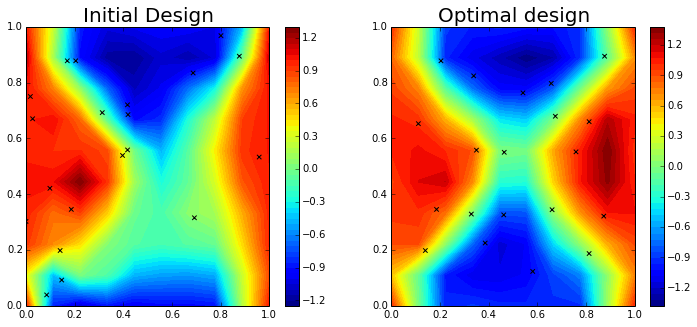

In [98]:
mean_init, cov_init = sample_forward_posterior(0.04, true_solutions, init_ls, 1e-3, 500, initial_design, true_solution_ix, test)
mean_opt, cov_opt = sample_forward_posterior(0.04, true_solutions, init_ls, 1e-3, 500, collocate_interior, true_solution_ix, test)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.contourf(test_x, test_y, mean_init.mean(axis=0).reshape(test_x.shape), 50)
plt.colorbar()
plt.title('Initial Design', fontsize=20)
plt.xlim([0,1]); plt.ylim([0,1])
plt.scatter(initial_design[:,0], initial_design[:,1], marker='x', c='black')
plt.subplot(122)
plt.contourf(test_x, test_y, mean_opt.mean(axis=0).reshape(test_x.shape), 50)
plt.colorbar()
plt.scatter(collocate_interior[:,0], collocate_interior[:,1], marker='x', c='black')
plt.title('Optimal design', fontsize=20)
plt.xlim([0,1]); plt.ylim([0,1])
plt.savefig('figures/ac_designs_n={}.pdf'.format(n_pts), transparent=True, bbox_inches=0)

In [99]:
cur_solutions = find_solutions(0.04, 25)
e = log_p_pn_estimate(true_obs, 0.04, true_solutions, init_ls, noise_variance, 1.0, 1, true_solution_ix, collocate_interior, debug=True)
print('Mean / std like: ', np.mean(e), np.std(e))

2.50134209852 2.50294209852
i=0: Log-PN Proba: -2281.73609849 Discrepancy: -0.0189460493618
Mean / std like:  -2281.73609849 0.0


# MCMC

In [100]:
class LikelihoodClass(object):
    def __init__(self, solutions, solutions_delta, design, mesh_size):
        self.__solutions__ = solutions
        self.__solutions_delta__ = solutions_delta
        self.__design__ = design
        self.__mesh_size__ = mesh_size
    
    def likelihood(self, solution_ix, delta, ls):
        if delta != self.__solutions_delta__:
            solutions = find_solutions(delta, self.__mesh_size__, initial_guesses=self.__solutions__)
            self.__solutions__ = solutions
            self.__solutions_delta__ = delta
        else:
            solutions = self.__solutions__
        if not use_fem:
            ret = log_p_pn_estimate(true_obs, 
                                    delta, 
                                    solutions, 
                                    ls, 
                                    noise_variance,
                                    z_proposal_variance,
                                    z_samples,
                                    solution_ix,
                                    self.__design__
                                   )
        else:
            true_locations, true_values = true_obs
            solution = np.vectorize(solutions[solution_ix])
            evaluated_solution = solution(true_locations[:,0], true_locations[:,1])
            return scipy.stats.multivariate_normal.logpdf(evaluated_solution, true_values, noise_variance**2)
        
        if z_samples == 1:
            return ret
        return np.mean(ret)
        #return np.mean(ret)
    
    def __call__(self, sample):
        solution_ix = int(sample[0])
        delta = sample[1]
        ls = sample[2]
        return self.likelihood(solution_ix, delta, ls)

In [101]:
## import sys
# lastly put all of this together to sample from the delta distribution
n_iter = 10000

delta_min = 0.02
delta_max = 0.15

def delta_log_prior(delta):
    if delta[1] > delta_max or delta[1] < delta_min:
        return -np.inf
    return scipy.stats.halfcauchy.logpdf(delta[2])

#prev_delta = (delta_max + delta_min) / 2.
prev_delta = 0.04
#delta_proposal_variance = 1e-1 # n=5
#ls_proposal_variance = 0.08 # n=5
delta_proposal_variance = 1e-2 # n=40
ls_proposal_variance = 0.01 # n=40
#delta_proposal_variance = 5e-3 # need this at n=80
z_proposal_variance = 0.5
z_samples = 1000

cur_solutions = find_solutions(prev_delta, fem_mesh_size)

likelihood = LikelihoodClass(cur_solutions, prev_delta, design_points, fem_mesh_size)
class ProposalClass(object):
    def __init__(self):
        self.proposal_ix = 0
        
    def propose_delta(self, delta):
        return np.random.normal(delta, delta_proposal_variance)
    
    def propose_ls(self, ls):
        return np.random.normal(ls, ls_proposal_variance)
    
    def propose_solution(self):
        return np.random.choice(3)
    
    def __call__(self, current):
        if self.proposal_ix == 0:
            solution = current[0]
            delta = self.propose_delta(current[1])
            ls = self.propose_ls(current[2]) if sample_ls else current[2]
        else:
            solution = self.propose_solution()
            delta = current[1]
            ls = current[2]
        self.proposal_ix = 1 if self.proposal_ix == 0 else 0
        return np.array([solution, delta, ls])
propose = ProposalClass()

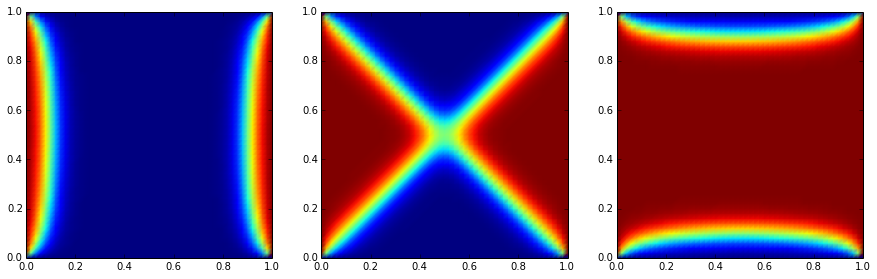

In [102]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plot(cur_solutions[0]); 
plt.subplot(132)
plot(cur_solutions[1]); 
plt.subplot(133)
plot(cur_solutions[2])

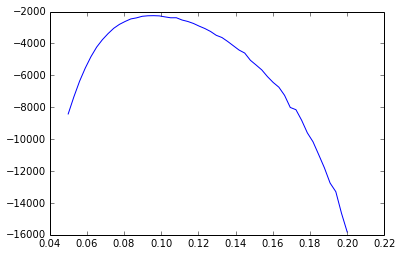

In [103]:
length_scales = np.linspace(0.05, 0.2)
likelihoods = np.empty_like(length_scales)
for i, ls in enumerate(length_scales):
    try:
        likelihoods[i] = likelihood(np.array([1, 0.04, ls])) + delta_log_prior([1, 0.04, ls])
    except Exception as ex:
        break
plt.plot(length_scales, likelihoods)
opt_ls = length_scales[np.argmax(likelihoods)]

In [104]:
deltas = np.linspace(delta_min, 0.08, 50)
likelihoods = np.empty_like(deltas)
for i, delta in enumerate(deltas):
    likelihoods[i] = likelihood(np.array([1, delta, opt_ls])) + delta_log_prior([1, delta, opt_ls])

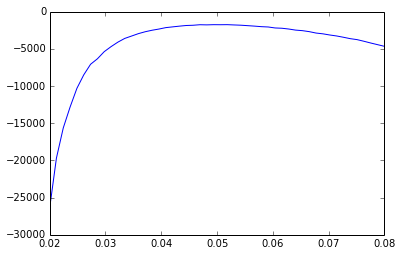

In [ ]:
plt.plot(deltas, likelihoods)

In [ ]:
samples = mcmc.rwm(n_iter, propose, likelihood, delta_log_prior, np.array([0, 0.04, opt_ls]))

In [ ]:
if use_fem:
    out_name = 'allen_cahn_results/delta_fem_n={}.npy'.format(fem_mesh_size)
elif sample_ls:
    if bayesian_approach:
        out_name = 'allen_cahn_results/delta_sigma_n={}.npy'.format(n_pts)
    else:
        out_name = 'allen_cahn_results/delta_sigma_collocation_n={}.npy'.format(n_pts)
else:
    out_name = 'allen_cahn_results/delta_n={}.npy'.format(n_pts)
np.save(out_name, samples)

In [ ]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot

In [ ]:
burn = 0
thin = 1
for ix in [1,2]:
    thinned_burned = samples[burn::thin,ix]
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.plot(thinned_burned)
    print(np.mean(thinned_burned))
    ax = plt.subplot(132)
    autocorrelation_plot(thinned_burned, ax)
    plt.subplot(133)
    kde = scipy.stats.gaussian_kde(thinned_burned.T, bw_method=0.3)
    range = np.linspace(delta_min, 0.08, 500)
    plt.plot(range, kde(range))

In [ ]:
for n in [10, 20, 40, 80]:
    samples = np.load('allen_cahn_results/delta_sigma_n={}.npy'.format(n))
    delta = samples[:,1]
    kde = scipy.stats.gaussian_kde(delta.T, bw_method=0.3)
    range = np.linspace(delta_min, 0.08, 500)
    plt.plot(range, kde(range), label='n={}'.format(n))
plt.axvline(0.04, linestyle='--', c='gray')
plt.xlabel('$\\delta$', fontsize=20)
plt.legend()
#plt.gca().get_yaxis().set_visible(False)